In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

warnings.filterwarnings('ignore')

In [3]:
raw_data = pd.read_csv(r'C:\Users\user\Desktop\bank_transactions.csv')

In [4]:
raw_data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


**Exploratory Data Analysis**

In [6]:
raw_data.columns.values

array(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'], dtype=object)

In [7]:
#print the shape of the dataset
print("shape of the dataset (rows, columns):", raw_data.shape)

shape of the dataset (rows, columns): (1048567, 9)


In [8]:
#data types and memory usage
print("\nData types and memory usage:")
print(raw_data.info(memory_usage='deep'))


Data types and memory usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 403.5 MB
None


In [9]:
#number of unique customers
unique_customers = raw_data['CustomerID'].nunique()

In [10]:
unique_customers

884265

In [11]:
#check for missing values
raw_data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [12]:
#check for duplicate rows (full row duplicates)
raw_data.duplicated().sum()

0

In [13]:
#check for partial duplicates on transaction ID
raw_data['TransactionID'].duplicated().sum()

0

In [14]:
#check for partial duplicates on customer ID
# this means many customers have multiple transactions, which is expected.
#It reinforces the need to aggregate to customer-level.
raw_data['CustomerID'].duplicated().sum()

164302

In [15]:
#clean and format TransactionTime
raw_data['TransactionTime'] = raw_data['TransactionTime'].astype(str).str.zfill(6)
raw_data['TransactionTime'] = raw_data['TransactionTime'].str.replace(
    r'(\d{2})(\d{2})(\d{2})', r'\1:\2:\3', regex=True
)

In [16]:
#convert TransactionDate to string
raw_data['TransactionDate'] = raw_data['TransactionDate'].astype(str)

In [17]:
# Combine into a single datetime column
raw_data['Transaction Timestamp'] = pd.to_datetime(
    raw_data['TransactionDate'] + ' ' + raw_data['TransactionTime'],
    errors='coerce'
)

In [18]:
# Check for duplicates by Customer ID + exact timestamp
# this shows exact duplicate transactions per customer (same timestamp)
#it could be due to system retries, scheduled transactions, or data entry issues
duplicate_customer_ts = raw_data.duplicated(subset=['CustomerID', 'Transaction Timestamp']).sum()
print(f"Number of duplicated (Customer ID + Timestamp): {duplicate_customer_ts}")

Number of duplicated (Customer ID + Timestamp): 0


**Dealing with missing values and duplicates**

In [20]:
# Remove exact duplicates on Customer ID + Timestamp
clean_data = raw_data.drop_duplicates(subset=['CustomerID', 'Transaction Timestamp'])

In [21]:
clean_data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
Transaction Timestamp         0
dtype: int64

In [22]:
#fill the missing values in customer account balance with the median
# Calculate the median of CustAccountBalance
balance_median = clean_data['CustAccountBalance'].median()

In [23]:
# Fill missing values with the median
clean_data['CustAccountBalance'] = clean_data['CustAccountBalance'].fillna(balance_median)

In [24]:
# Drop customers with missing DOBs
clean_data = clean_data[clean_data['CustomerDOB'].notna()]

In [25]:
# Fill missing genders with 'Unknown'
clean_data['CustGender'] = clean_data['CustGender'].fillna('Unknown')

In [26]:
#fill missing location with unspecified
clean_data['CustLocation'] = clean_data['CustLocation'].fillna('Unspecified')

In [27]:
#check again for missing values
clean_data.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
Transaction Timestamp      0
dtype: int64

**View the probability distribution function of CustAccountBalance and TransactionAmount (INR)**

<Axes: xlabel='CustAccountBalance', ylabel='Density'>

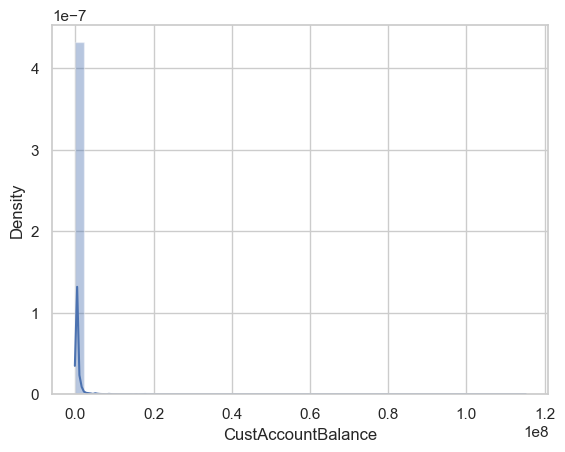

In [29]:
#before removing outliers
sns.distplot(clean_data['CustAccountBalance'])

In [30]:
#remove outliers using the quantile method
q = clean_data['CustAccountBalance'].quantile(0.99)
data_1 = clean_data[clean_data['CustAccountBalance']<q]

<Axes: xlabel='CustAccountBalance', ylabel='Density'>

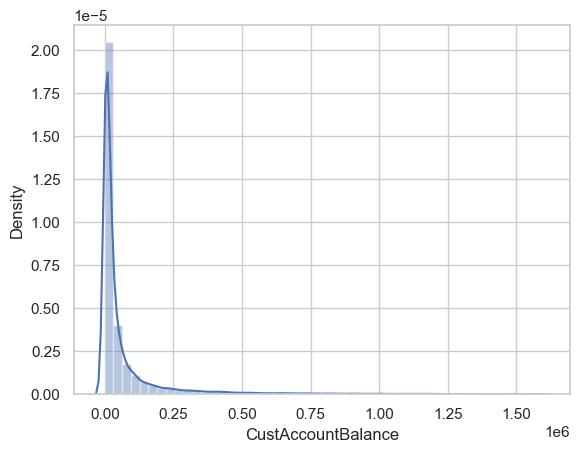

In [31]:
#after removing outliers in CustAccountBalance
sns.distplot(data_1['CustAccountBalance'])

<Axes: xlabel='TransactionAmount (INR)', ylabel='Density'>

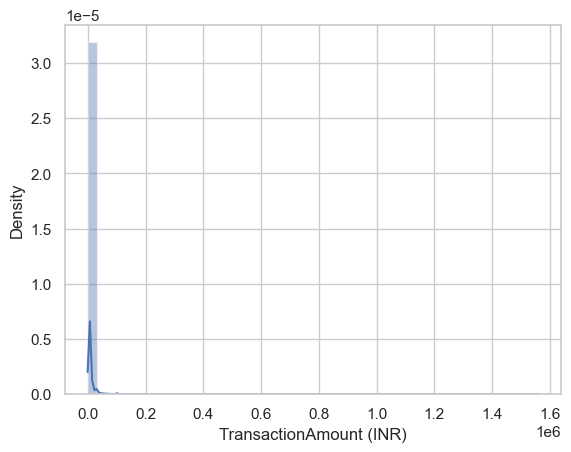

In [32]:
#before removing outliers
sns.distplot(clean_data['TransactionAmount (INR)'])

In [33]:
#remove outliers using the quantile method
q = clean_data['TransactionAmount (INR)'].quantile(0.99)
data_2 = data_1[data_1['TransactionAmount (INR)']<q]

<Axes: xlabel='TransactionAmount (INR)', ylabel='Density'>

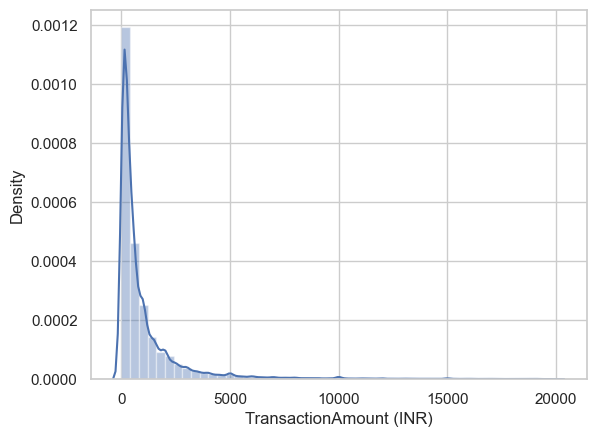

In [34]:
#after removing outliers in TransactionAmount (INR)
sns.distplot(data_2['TransactionAmount (INR)'])

**Apply log transformation to account balance and transaction amount**

In [36]:
# Apply log1p to handle zero values safely
data_2['log_balance'] = np.log1p(data_2['CustAccountBalance'])
data_2['log_txn_amount'] = np.log1p(data_2['TransactionAmount (INR)'])

In [37]:
data_2

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Transaction Timestamp,log_balance,log_txn_amount
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,14:32:07,25.0,2016-02-08 14:32:07,9.788080,3.258097
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,14:27:12,459.0,2016-02-08 14:27:12,9.791183,6.131226
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,14:27:14,2060.0,2016-02-08 14:27:14,13.672222,7.630947
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,18:11:56,1762.5,2016-02-08 18:11:56,8.812163,7.475056
5,T6,C1536588,8/10/72,F,ITANAGAR,53609.20,2/8/16,17:39:40,676.0,2016-02-08 17:39:40,10.889495,6.517671
...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,18:48:24,799.0,2016-09-18 18:48:24,8.940654,6.684612
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,18:37:34,460.0,2016-09-18 18:37:34,10.215097,6.133398
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,18:33:13,770.0,2016-09-18 18:33:13,12.309342,6.647688
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,18:47:06,1000.0,2016-09-18 18:47:06,9.222157,6.908755


**Address the same CustomerID with different DOB and Gender issue**

In [39]:
#created a function to get the most frequent value (mode) or NaN if there's a tie
def most_frequent(series):
    counts = series.dropna().value_counts()
    if counts.empty:
        return np.nan
    else:
        return counts.idxmax()

In [40]:
#identify customers with multiple DOBs or Genders
dob_counts = data_2.groupby('CustomerID')['CustomerDOB'].nunique()
gender_counts = data_2.groupby('CustomerID')['CustGender'].nunique()

In [41]:
dob_counts

CustomerID
C1010011    2
C1010012    1
C1010014    2
C1010018    1
C1010024    1
           ..
C9099836    1
C9099877    1
C9099919    1
C9099941    1
C9099956    1
Name: CustomerDOB, Length: 867267, dtype: int64

In [42]:
gender_counts

CustomerID
C1010011    2
C1010012    1
C1010014    2
C1010018    1
C1010024    1
           ..
C9099836    1
C9099877    1
C9099919    1
C9099941    1
C9099956    1
Name: CustGender, Length: 867267, dtype: int64

In [43]:
# Customers with multiple DOBs
dob_issues = dob_counts[dob_counts > 1]
print(f"Customers with inconsistent DOBs: {len(dob_issues)}")

Customers with inconsistent DOBs: 136565


In [44]:
# Customers with multiple Genders
gender_issues = gender_counts[gender_counts > 1]
print(f"Customers with inconsistent Genders: {len(gender_issues)}")

Customers with inconsistent Genders: 57740


In [45]:
data_2.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
Transaction Timestamp      0
log_balance                0
log_txn_amount             0
dtype: int64

In [46]:
customer_profiles = (
    data_2
    .groupby('CustomerID')[['CustomerDOB', 'CustGender', 'CustLocation']]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .reset_index()
)

In [47]:
#convert DOB to datetime format
customer_profiles['CustomerDOB'] = pd.to_datetime(customer_profiles['CustomerDOB'], errors='coerce')

In [48]:
# Derive Age (as of latest transaction date)
data_2['TransactionDate'] = pd.to_datetime(data_2['TransactionDate'], errors='coerce')
latest_txn_date = data_2['TransactionDate'].max()
customer_profiles['Age'] = customer_profiles['CustomerDOB'].apply(
    lambda dob: latest_txn_date.year - dob.year if pd.notnull(dob) else np.nan
)

In [49]:
# Preview the cleaned customer master table
display(customer_profiles.head())

,CustomerID,CustomerDOB,CustGender,CustLocation,Age
0,C1010011,1992-08-19,F,NEW DELHI,24
1,C1010012,1994-07-28,M,MUMBAI,22
2,C1010014,1984-08-19,F,MUMBAI,32
3,C1010018,1990-05-29,F,CHAMPARAN,26
4,C1010024,2065-06-21,M,KOLKATA,-49


The preview above shows there is an issue with the DOB column because some data points under the age column are negative

I have to replace the negative age with the valid median age.

In [51]:
# Filter customers with negative age
negative_age_customers = customer_profiles[customer_profiles['Age'] < 0]

# Display the result
display(negative_age_customers)

,CustomerID,CustomerDOB,CustGender,CustLocation,Age
4,C1010024,2065-06-21,M,KOLKATA,-49
31,C1010112,2068-03-10,M,GURGAON,-52
39,C1010133,2070-07-17,M,SURAT,-54
44,C1010161,2055-12-15,F,CHENNAI,-39
53,C1010212,2055-04-29,F,DURGAPUR,-39
...,...,...,...,...,...
867215,C9098270,2073-07-27,F,PUNE,-57
867229,C9098760,2071-07-08,M,DELHI,-55
867237,C9099023,2045-09-13,M,JIND,-29
867241,C9099142,2070-10-02,M,CHENNAI,-54


In [52]:
# Count of customers with negative age
negative_age_customers.shape[0]

83657

In [53]:
# Compute median of valid ages
median_age = customer_profiles[customer_profiles['Age'] >= 0]['Age'].median()

In [54]:
# Replace negative ages with median
customer_profiles.loc[customer_profiles['Age'] < 0, 'Age'] = median_age

In [55]:
customer_profiles

,CustomerID,CustomerDOB,CustGender,CustLocation,Age
0,C1010011,1992-08-19,F,NEW DELHI,24
1,C1010012,1994-07-28,M,MUMBAI,22
2,C1010014,1984-08-19,F,MUMBAI,32
3,C1010018,1990-05-29,F,CHAMPARAN,26
4,C1010024,2065-06-21,M,KOLKATA,28
...,...,...,...,...,...
867262,C9099836,1990-12-24,M,BHIWANDI,26
867263,C9099877,1996-09-06,M,BANGALORE,20
867264,C9099919,1993-10-21,M,GUNTUR,23
867265,C9099941,1995-04-22,M,CHENNAI,21


In [56]:
# Filter customers with negative age
negative_age_customers = customer_profiles[customer_profiles['Age'] < 0]

In [57]:
# Count of customers with negative age
negative_age_customers.shape[0]

0

In [58]:
#I no longer need the CustomerDOB column
customer_profiles.drop(columns=['CustomerDOB'], inplace=True)

In [59]:
customer_profiles

,CustomerID,CustGender,CustLocation,Age
0,C1010011,F,NEW DELHI,24
1,C1010012,M,MUMBAI,22
2,C1010014,F,MUMBAI,32
3,C1010018,F,CHAMPARAN,26
4,C1010024,M,KOLKATA,28
...,...,...,...,...
867262,C9099836,M,BHIWANDI,26
867263,C9099877,M,BANGALORE,20
867264,C9099919,M,GUNTUR,23
867265,C9099941,M,CHENNAI,21


**Creating the RFM table**

In [126]:
#make a copy of data_2 and delete unwanted columns
data_3 = data_2.copy()

In [128]:
data_3

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Transaction Timestamp,log_balance,log_txn_amount
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,2016-02-08 14:32:07,9.788080,3.258097
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,2016-02-08 14:27:12,9.791183,6.131226
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,2016-02-08 14:27:14,13.672222,7.630947
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,2016-02-08 18:11:56,8.812163,7.475056
5,T6,C1536588,8/10/72,F,ITANAGAR,53609.20,2016-02-08,17:39:40,676.0,2016-02-08 17:39:40,10.889495,6.517671
...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,2016-09-18,18:48:24,799.0,2016-09-18 18:48:24,8.940654,6.684612
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0,2016-09-18 18:37:34,10.215097,6.133398
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0,2016-09-18 18:33:13,12.309342,6.647688
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0,2016-09-18 18:47:06,9.222157,6.908755


In [130]:
#specify the columns to drop
columns_to_drop = ['CustomerDOB', 'CustAccountBalance', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)']

In [132]:
#drop them from the data
data_3 = data_3.drop(columns=columns_to_drop)

In [134]:
data_3

,TransactionID,CustomerID,CustGender,CustLocation,Transaction Timestamp,log_balance,log_txn_amount
0,T1,C5841053,F,JAMSHEDPUR,2016-02-08 14:32:07,9.788080,3.258097
2,T3,C4417068,F,MUMBAI,2016-02-08 14:27:12,9.791183,6.131226
3,T4,C5342380,F,MUMBAI,2016-02-08 14:27:14,13.672222,7.630947
4,T5,C9031234,F,NAVI MUMBAI,2016-02-08 18:11:56,8.812163,7.475056
5,T6,C1536588,F,ITANAGAR,2016-02-08 17:39:40,10.889495,6.517671
...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,M,NEW DELHI,2016-09-18 18:48:24,8.940654,6.684612
1048563,T1048564,C6459278,M,NASHIK,2016-09-18 18:37:34,10.215097,6.133398
1048564,T1048565,C6412354,M,HYDERABAD,2016-09-18 18:33:13,12.309342,6.647688
1048565,T1048566,C6420483,M,VISAKHAPATNAM,2016-09-18 18:47:06,9.222157,6.908755


In [136]:
#group data_3 by customer ID and get aggregates
grouped = data_3.groupby('CustomerID').agg({
    'Transaction Timestamp': ['min', 'max', 'count'],
    'log_balance': 'mean',
    'log_txn_amount': 'mean'
})

In [138]:
# Use the latest transaction date in the data as 'today'
today = data_3['Transaction Timestamp'].max()

In [140]:
# Group and aggregate
rfm = data_3.groupby('CustomerID').agg({
    'Transaction Timestamp': lambda x: (today - x.max()).days,   # Recency
    'TransactionID': 'count',                                    # Frequency
    'log_txn_amount': ['mean', 'sum']                      # Monetary: Avg and Total
}).reset_index()

In [142]:
# rename the column names
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'AvgMonetary', 'TotalMonetary']

In [144]:
rfm

,CustomerID,Recency,Frequency,AvgMonetary,TotalMonetary
0,C1010011,74,2,7.171923,14.343846
1,C1010012,117,1,7.313220,7.313220
2,C1010014,154,2,6.310259,12.620517
3,C1010018,85,1,3.433987,3.433987
4,C1010024,113,1,8.517393,8.517393
...,...,...,...,...,...
867262,C9099836,154,1,6.539586,6.539586
867263,C9099877,85,1,5.407172,5.407172
867264,C9099919,113,1,4.844187,4.844187
867265,C9099941,103,1,3.931826,3.931826


In [146]:
#save customer profiles and rfm to excel file with multiple sheets
with pd.ExcelWriter('customer_segmentation_tables.xlsx') as writer:
    customer_profiles.to_excel(writer, sheet_name='CustomerProfiles', index=False)
    rfm.to_excel(writer, sheet_name='RFM', index=False)

**Create the complete customer features table**

In [149]:
# Merge the RFM table with customer_profiles
customer_features = customer_profiles.merge(rfm, on='CustomerID', how='inner')

In [151]:
customer_features

,CustomerID,CustGender,CustLocation,Age,Recency,Frequency,AvgMonetary,TotalMonetary
0,C1010011,F,NEW DELHI,24,74,2,7.171923,14.343846
1,C1010012,M,MUMBAI,22,117,1,7.313220,7.313220
2,C1010014,F,MUMBAI,32,154,2,6.310259,12.620517
3,C1010018,F,CHAMPARAN,26,85,1,3.433987,3.433987
4,C1010024,M,KOLKATA,28,113,1,8.517393,8.517393
...,...,...,...,...,...,...,...,...
867262,C9099836,M,BHIWANDI,26,154,1,6.539586,6.539586
867263,C9099877,M,BANGALORE,20,85,1,5.407172,5.407172
867264,C9099919,M,GUNTUR,23,113,1,4.844187,4.844187
867265,C9099941,M,CHENNAI,21,103,1,3.931826,3.931826


In [153]:
customer_features.to_csv('customer_features.csv', index=False)